In [ ]:
from google.colab import drive        # Import the 'drive' module to interact with Google Drive
drive.mount('/content/drive')         # Mount your Google Drive to the Colab environment


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import Libraries

In [ ]:
!pip install resampy

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load Data

In [ ]:
audio_files_path = "/content/drive/MyDrive/Audio/dataset_folder/KAGGLE/AUDIO/"

In [ ]:
folders = os.listdir(audio_files_path)  # Get a list of folders in the specified path
print(folders)                          # Print the list of folder names

['FAKE', 'REAL']


In [ ]:
real_audio = "/content/drive/MyDrive/Audio/dataset_folder/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/content/drive/MyDrive/Audio/dataset_folder/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Visualization

In [ ]:
print("Real Audio:")
#IPython.display.Audio(real_audio)

Real Audio:


In [ ]:
print("Fake Audio:")

Fake Audio:


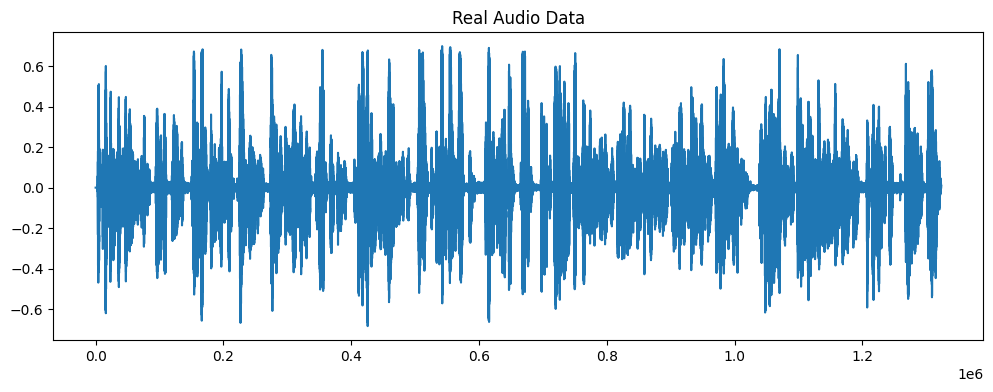

In [ ]:
real_ad, real_sr = librosa.load(real_audio)   # Load the real audio file
plt.figure(figsize=(12, 4))                   # Create a plot figure
plt.plot(real_ad)                             # Plot the audio waveform
plt.title("Real Audio Data")                  # Add a title to the plot
plt.show()                                    # Display the plot

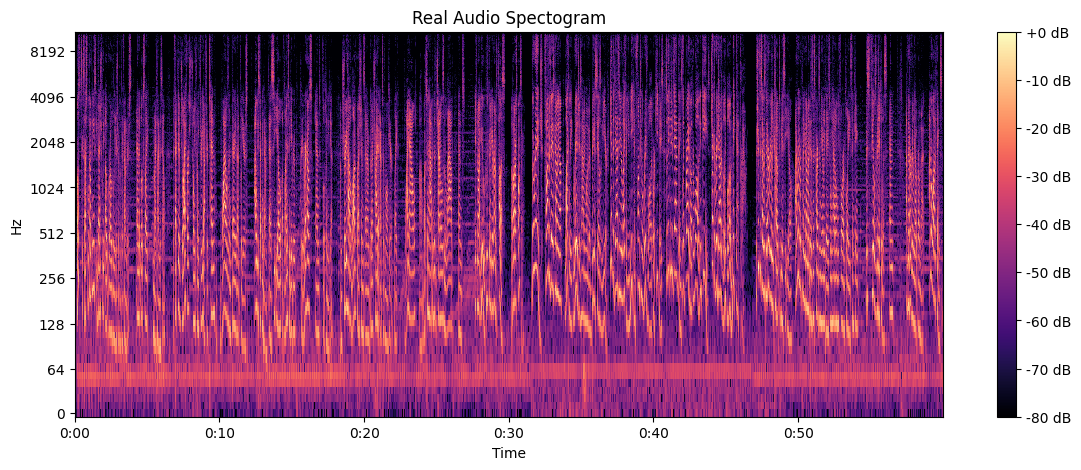

In [ ]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

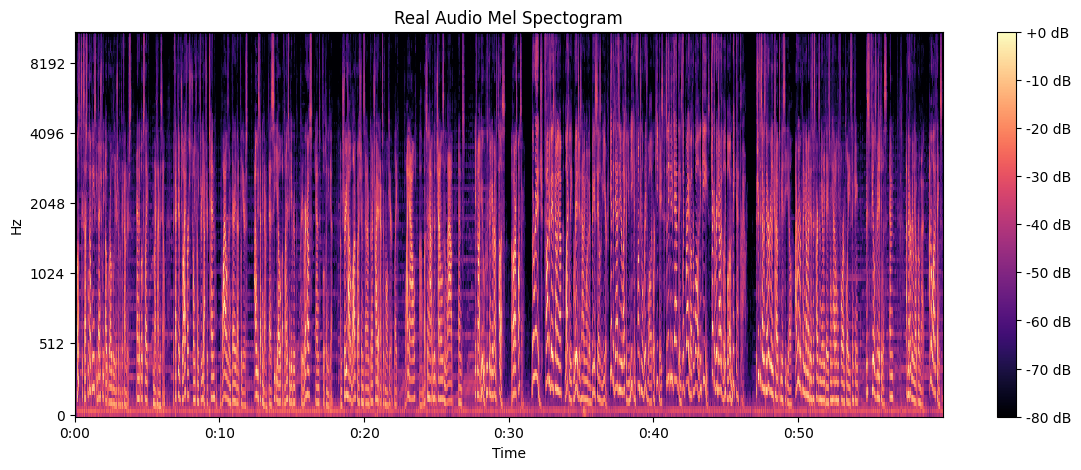

In [ ]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

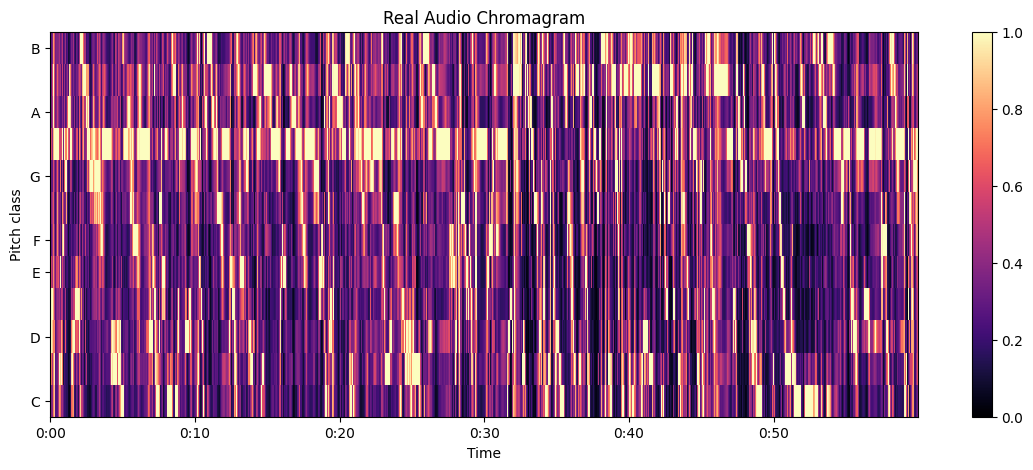

In [ ]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

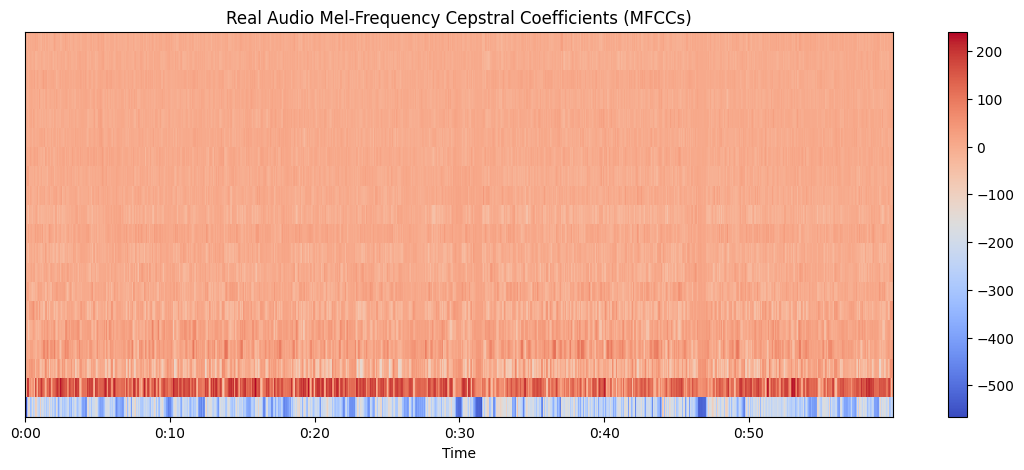

In [ ]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

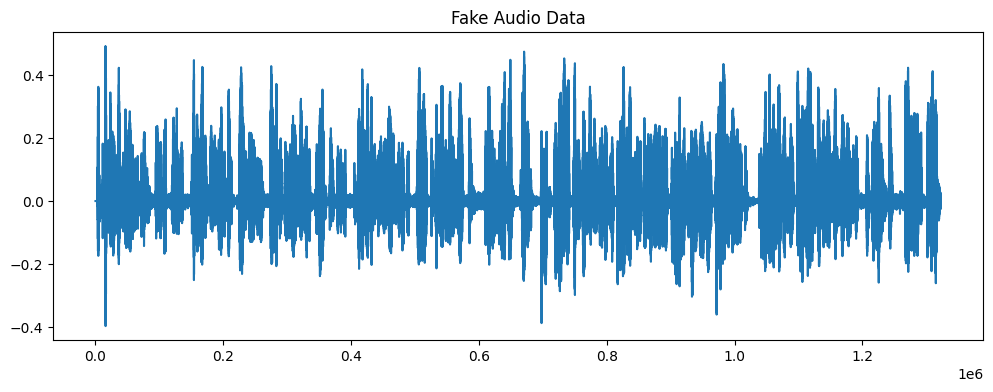

In [ ]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

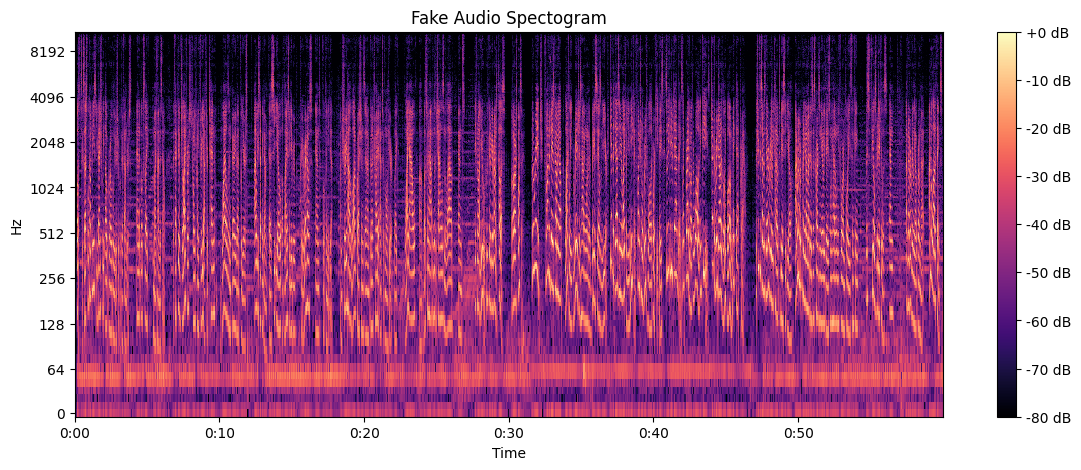

In [ ]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

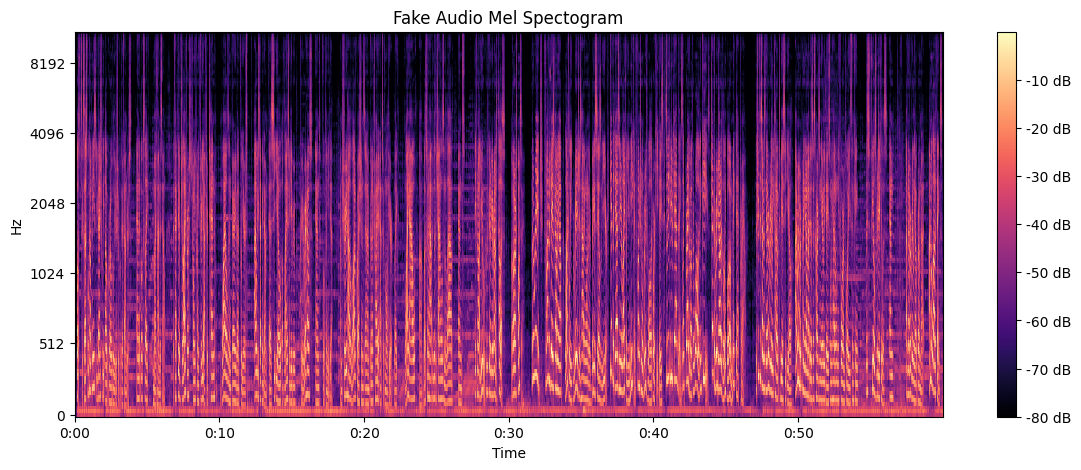

In [ ]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

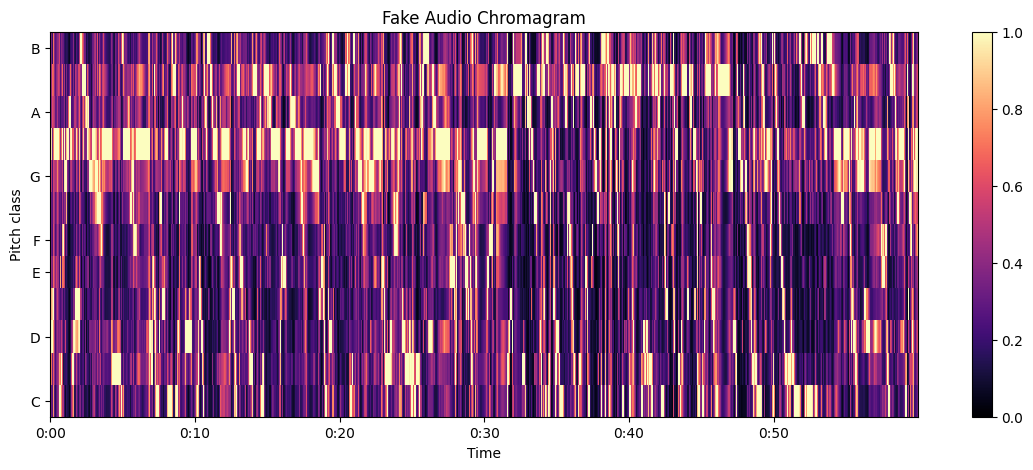

In [ ]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

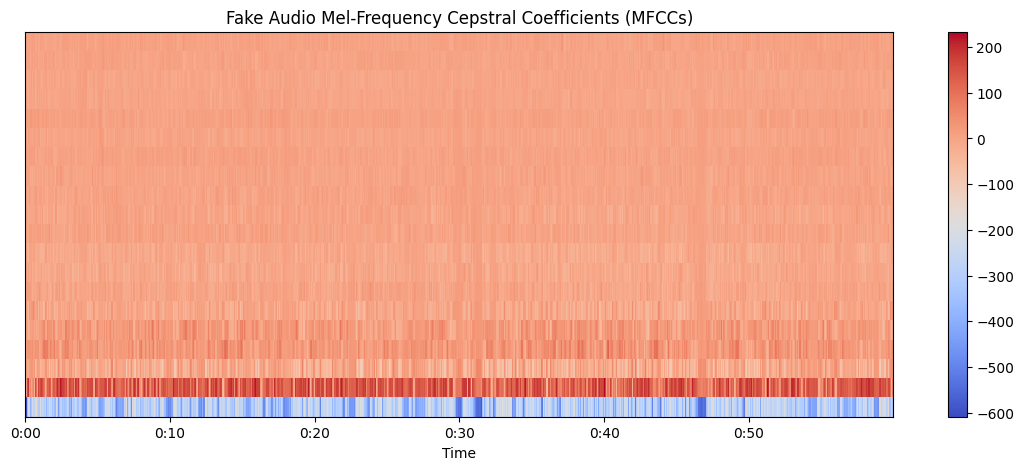

In [ ]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()


# Preprocess

In [ ]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [01:09<00:00,  8.65s/it]


In [ ]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

,features,class
0,"[-344.30576, 75.554665, -13.031928, 1.4159143,...",FAKE
1,"[-349.3125, 74.14648, -17.648636, 1.6684384, -...",FAKE
2,"[-272.68378, 101.50515, -22.251564, 4.101077, ...",FAKE
3,"[-280.70587, 90.476036, -29.340605, -1.4076414...",FAKE
4,"[-260.1085, 100.856926, -25.453161, -0.2690359...",FAKE


In [ ]:
feature_df["class"].value_counts()

FAKE    56
REAL     8
Name: class, dtype: int64

In [ ]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [ ]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


# Feature Scaling

In [ ]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
y_resampled = to_categorical(y_resampled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [ ]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# Model

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               5248      
                                                                 
 activation_8 (Activation)   (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 activation_9 (Activation)   (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [ ]:
early = EarlyStopping(monitor="val_loss", patience=10)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=1000, callbacks=[early])

Epoch 1/1000
45/45 [==============================] - 0s 6ms/step - loss: 0.5498 - accuracy: 0.7079 - val_loss: 0.6092 - val_accuracy: 0.5652
Epoch 2/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6742 - val_loss: 0.5902 - val_accuracy: 0.8261
Epoch 3/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.6292 - val_loss: 0.5707 - val_accuracy: 0.8696
Epoch 4/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6067 - val_loss: 0.5584 - val_accuracy: 0.7826
Epoch 5/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.5642 - accuracy: 0.6517 - val_loss: 0.5611 - val_accuracy: 0.8261
Epoch 6/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.5824 - accuracy: 0.6742 - val_loss: 0.5518 - val_accuracy: 0.7826
Epoch 7/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.5883 - accuracy: 0.6517 - val_loss: 0.5482 - val_accuracy: 0.8261
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/Audio/dataset_folder/my_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - 0s 26ms/step - loss: 0.3341 - accuracy: 0.9130
Test Loss: 0.33405929803848267
Test Accuracy: 0.9130434989929199


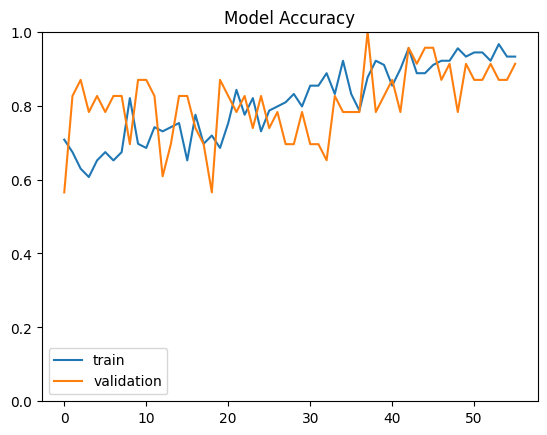

In [ ]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

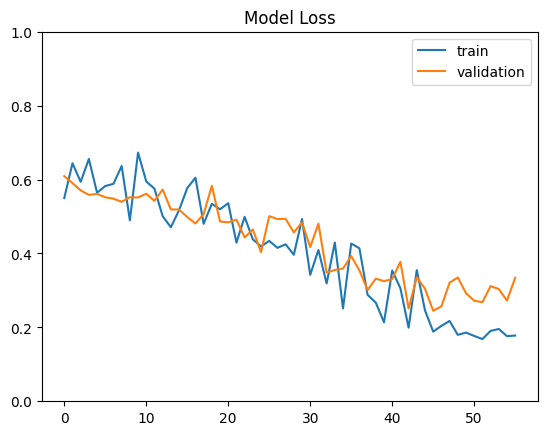

In [ ]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [ ]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [ ]:
test_real = "/content/drive/MyDrive/Audio/dataset_folder/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/content/drive/MyDrive/Audio/dataset_folder/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [ ]:
detect_fake(test_fake)

1/1 [==============================] - 0s 31ms/step
[[0.87711924 0.12288077]]
Result: FAKE


In [ ]:
detect_fake(test_real)

1/1 [==============================] - 0s 33ms/step
[[0.02188714 0.9781129 ]]
Result: REAL


In [ ]:
print(tf.__version__)

2.15.0
